In [9]:
# -----------------------------
# Cell 1: Setup paths
# -----------------------------
import sys
from pathlib import Path

# Notebook location
notebook_path = Path().resolve()  # current notebook folder
project_root = notebook_path.parent.parent  # Notebook/ -> project root
src_path = project_root / "src"


# Current notebook folder
notebook_path = Path().resolve()


# Add to Python path
sys.path.insert(0, str(src_path))
sys.path.insert(0, str(project_root))

print("Notebook path:", notebook_path)
print("Project root:", project_root)
print("SRC path:", src_path)

Notebook path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\notebooks\analysis
Project root: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics
SRC path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\src


In [10]:
import pandas as pd
import logging
import seaborn as sns

# Custom imports
from fintech_app_reviews.config import load_config
from fintech_app_reviews.viz.plots import (plot_ratings_per_bank,
                                               plot_sentiment_per_bank,
                                               plot_theme_distribution)

# Setup logging

logging.basicConfig(level=logging.INFO,
format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

In [11]:
# Config path at project root
config_path = project_root / "configs" / "nlp.yaml"

# Load NLP config
nlp_cfg = load_config(config_path)


output_path = project_root / \
    nlp_cfg["output"].get(
        "enriched_output_path")
    
print("Output path:", output_path) 

df = pd.read_csv(output_path )

df["txt_clean"] = df["txt_clean"].fillna("")
df["bank"] = df["bank"].fillna("Unknown")

# Quick check
df.head(3)
    

Output path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\data\processed\nlp_enriched_reviews.csv


,review,rating,date,bank,source,review_id,txt_clean,sentiment_label,sentiment_score,keywords,themes,theme_primary,theme_secondary,all_themes
0,it's special for me,5,2025-11-29,Commercial Bank of Ethiopia (CBE),google_play,e50abba56198b64fea14c92cb296a812,special,positive,0.999722,NaN,[],NaN,NaN,NaN
1,this application is very important and advanta...,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,f1d6f69ca166080c58144f24eda573df,application important advantage transfer money...,positive,0.732493,money|transfer|application,['Transaction Performance'],Transaction Performance,NaN,Transaction Performance
2,why didn't work this app?,1,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,a8a77f73bae35ee743144b577950d2b6,work app,positive,0.978127,app|work,[],NaN,NaN,NaN


In [12]:
# Count themes per bank
theme_counts = df.explode("themes").groupby("bank")["themes"].value_counts()
theme_counts = theme_counts.unstack(fill_value=0)

# Identify top 2 themes (drivers/pain points)
drivers_pain_points = {}
for bank in theme_counts.index:
    sorted_themes = theme_counts.loc[bank].sort_values(ascending=False)
    drivers_pain_points[bank] = {
        "driver": sorted_themes.index[0],
        "pain_point": sorted_themes.index[1] if len(sorted_themes) > 1 else sorted_themes.index[0]
    }

drivers_pain_points

{'Bank of Abyssinia (BOA)': {'driver': '[]',
  'pain_point': "['Transaction Performance']"},
 'Commercial Bank of Ethiopia (CBE)': {'driver': '[]',
  'pain_point': "['Feature Requests']"},
 'Dashen Bank': {'driver': '[]', 'pain_point': "['Feature Requests']"}}

2025-12-03 01:30:13,519 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-03 01:30:13,559 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


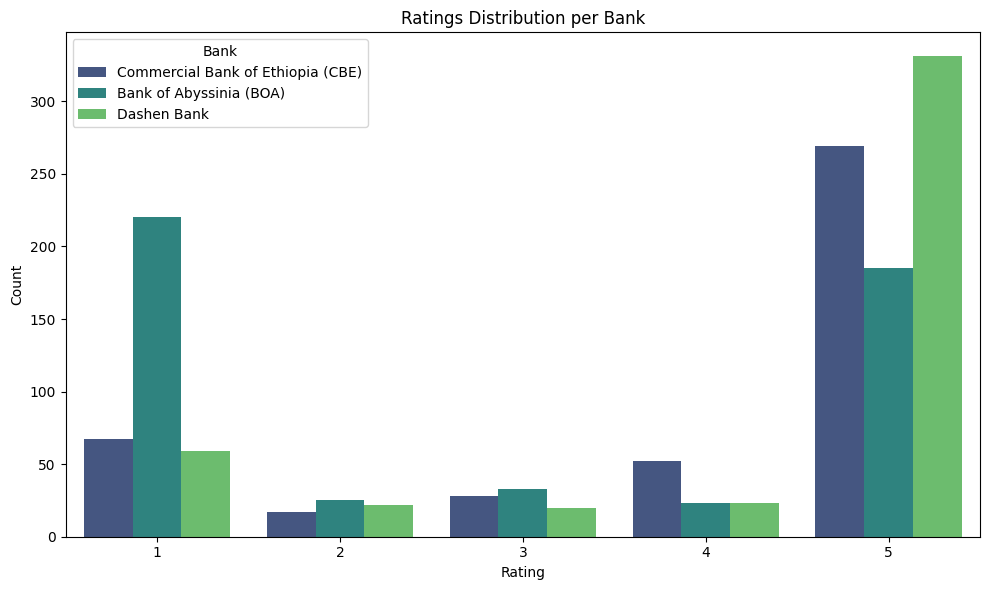

D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\src\fintech_app_reviews\viz\plots.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=bank_col, y=score_col, palette=palette)


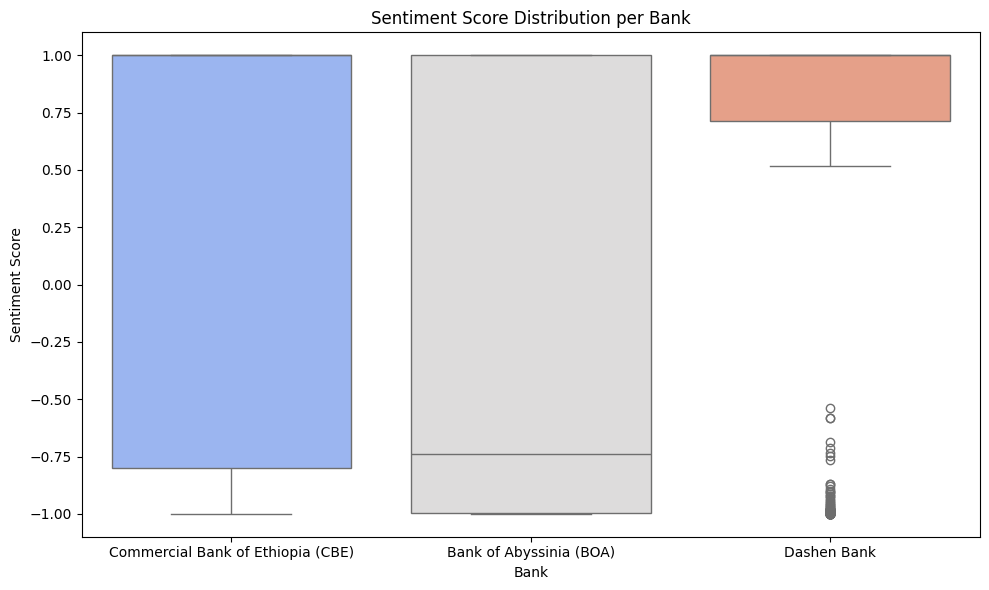

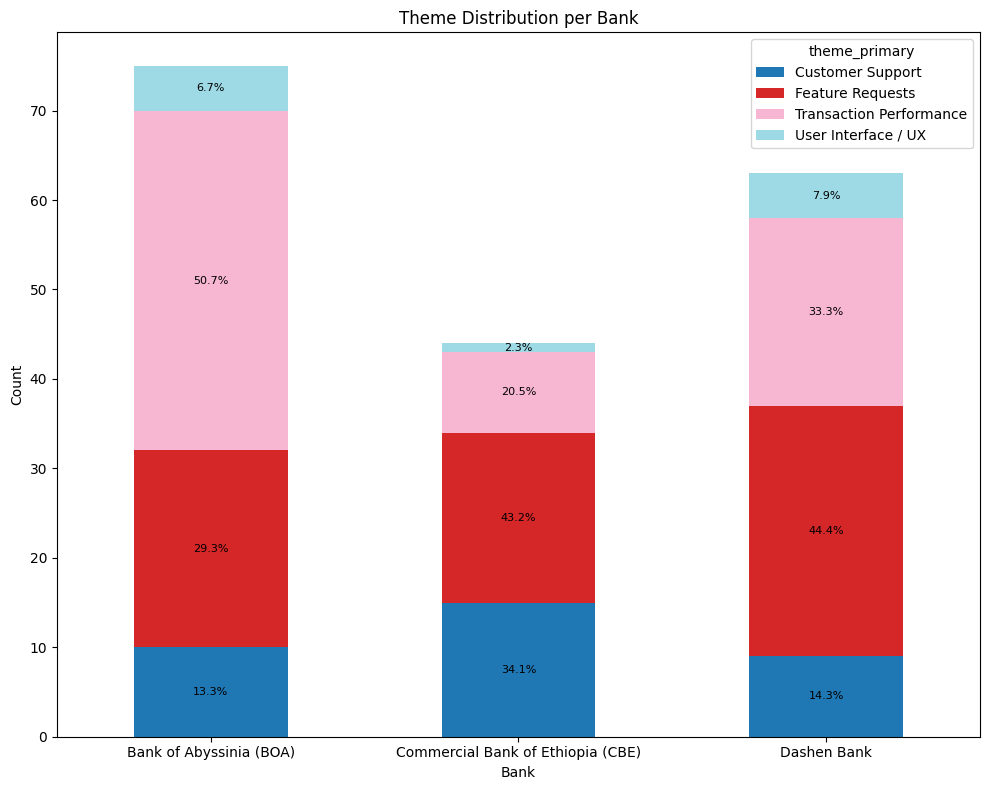

In [13]:
plot_ratings_per_bank(df)
plot_sentiment_per_bank(df)
plot_theme_distribution(df)

In [14]:
# Count themes per bank
theme_counts = df.explode("themes").groupby("bank")["themes"].value_counts()
theme_counts = theme_counts.unstack(fill_value=0)

# Identify top 2 themes (drivers/pain points)
drivers_pain_points = {}
for bank in theme_counts.index:
    sorted_themes = theme_counts.loc[bank].sort_values(ascending=False)
    drivers_pain_points[bank] = {
        "driver": sorted_themes.index[0],
        "pain_point": sorted_themes.index[1] if len(sorted_themes) > 1 else sorted_themes.index[0]
    }

drivers_pain_points

{'Bank of Abyssinia (BOA)': {'driver': '[]',
  'pain_point': "['Transaction Performance']"},
 'Commercial Bank of Ethiopia (CBE)': {'driver': '[]',
  'pain_point': "['Feature Requests']"},
 'Dashen Bank': {'driver': '[]', 'pain_point': "['Feature Requests']"}}

In [15]:
# Simple recommendations per bank
recommendations = {}
for bank, points in drivers_pain_points.items():
    recs = []
    if points["pain_point"]:
        recs.append(f"Fix issues related to '{points['pain_point']}'")
    if points["driver"]:
        recs.append(f"Enhance '{points['driver']}' experience")
    # generic suggestion
    recs.append("Consider adding features like budgeting tool or notifications")
    recommendations[bank] = recs

# Display
for bank, recs in recommendations.items():
    print(f"\n{bank} Recommendations:")
    for r in recs:
        print(f"- {r}")


Bank of Abyssinia (BOA) Recommendations:
- Fix issues related to '['Transaction Performance']'
- Enhance '[]' experience
- Consider adding features like budgeting tool or notifications

Commercial Bank of Ethiopia (CBE) Recommendations:
- Fix issues related to '['Feature Requests']'
- Enhance '[]' experience
- Consider adding features like budgeting tool or notifications

Dashen Bank Recommendations:
- Fix issues related to '['Feature Requests']'
- Enhance '[]' experience
- Consider adding features like budgeting tool or notifications
